In [95]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F

from IPython import display
display.set_matplotlib_formats('svg')

/tmp/ipykernel_1192/3683696129.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [96]:
train_data = np.loadtxt(open('train_mnist.csv','rb'),delimiter=',',skiprows=1)

# don't need labels!
train_data = train_data[:,1:]

# normalize the data to a range of [0 1]
train_dataNorm = train_data / np.max(train_data)

# convert to tensor
dataTrain = torch.tensor( train_dataNorm ).float()

dataTrain.shape

torch.Size([60000, 784])

In [97]:
test_data = np.loadtxt(open('test_mnist.csv','rb'),delimiter=',',skiprows=1)

# don't need labels!
test_data = test_data[:,1:]

# normalize the data to a range of [0 1]
test_dataNorm = test_data / np.max(test_data)

# convert to tensor
dataTest = torch.tensor( test_dataNorm ).float()

dataTest.shape

torch.Size([10000, 784])

In [98]:
class TiedAutoencoder(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,128)
      
      ### encoder layer
      self.enc = nn.Parameter(torch.randn(50,128))
      # self.enc = nn.Linear(128,50) # not used! left here for comparison

      ### latent layer (not used!)
      #self.lat = nn.Linear(50,128)

      ### decoder layer
      self.dec = nn.Linear(128,784)

    # forward pass
    def forward(self,x):
      # "normal" forward prop in first stage
      x = F.relu( self.input(x) )

      # a Parameter type is not a Linear type, so we implement the multiplication directly
      x = x.t() # need to transpose the input matrix due to multisample input matrices
      x = F.relu( self.enc@x )

      # same for the decoding layer but reversed
      x = F.relu( self.enc.t()@x )
      x = x.t() # and then transpose it back

      # "normal" final stage
      y = torch.sigmoid( self.dec(x) )
      return y

class UntiedAutoencoder(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,128)
      
      ### encoder layer
      self.enc = nn.Linear(128,50)

      ### latent layer
      self.lat = nn.Linear(50,128)

      ### decoder layer
      self.dec = nn.Linear(128,784)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.enc(x) )
      x = F.relu( self.lat(x) )
      y = torch.sigmoid( self.dec(x) )
      return y

In [99]:
def visualize_results(model, test_loader, num_images=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    
    with torch.no_grad():
        data, _ = next(iter(test_loader))
        data = data[:num_images].to(device)
        reconstructed = model(data)
        
        plt.figure(figsize=(12, 4))
        for i in range(num_images):
            # Original
            plt.subplot(2, num_images, i + 1)
            plt.imshow(data[i].cpu().view(28, 28), cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title('Original')
                
            # Reconstructed
            plt.subplot(2, num_images, num_images + i + 1)
            plt.imshow(reconstructed[i].cpu().view(28, 28), cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title('Reconstructed')
                
        plt.tight_layout()
        plt.show()

In [100]:
from torch.utils.data import DataLoader, TensorDataset

def load_mnist_data(dataTrain, dataTest, batch_size=128):
    """
    Load MNIST data from local CSV files and prepare DataLoaders
    """
    # Create datasets
    train_dataset = TensorDataset(dataTrain, dataTrain)  # Input = Target for autoencoder
    test_dataset = TensorDataset(dataTest, dataTest)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0], shuffle=False)
    
    return train_loader, test_loader

In [101]:
def plot_learning_curves(train_losses, test_losses, model_name):
    """Plot learning curves to visualize potential overfitting."""
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Epoch-wise training vs validation loss
    plt.subplot(1, 2, 1)
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, test_losses, 'r-', label='Validation Loss')
    plt.title(f'{model_name}: Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


In [102]:
def plot_all_losses(tied_train_losses, tied_test_losses, 
                    untied_train_losses, untied_test_losses):
    """
    Plot all losses on a single graph for comparison
    """
    plt.figure(figsize=(10, 5))
    epochs = np.arange(1, len(tied_train_losses) + 1)
    
    # Plot tied losses
    plt.plot(epochs, tied_train_losses, 'b-', label='Tied Training Loss', linewidth=2)
    plt.plot(epochs, tied_test_losses, 'b--', label='Tied Validation Loss', linewidth=2)
    
    # Plot untied losses
    plt.plot(epochs, untied_train_losses, 'r-', label='Untied Training Loss', linewidth=2)
    plt.plot(epochs, untied_test_losses, 'r--', label='Untied Validation Loss', linewidth=2)
    
    plt.title('Training and Validation Losses: Tied vs Untied Autoencoder')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend()
    
    # Add minor gridlines
    plt.grid(True, which="minor", ls=":", alpha=0.2)
    
    # Tight layout to prevent label cutoff
    plt.tight_layout()
    plt.show()

In [103]:
def train_model(model, data_train, data_test, epochs=10000, batch_size=32):
    learning_rate=1e-3
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = torch.zeros(epochs)
    test_losses = torch.zeros(epochs)
        
    for epochi in range(epochs):
        # Training
        model.train()

        # select a random set of images
        randomidx = np.random.choice(data_train.shape[0], size=batch_size)
        X = data_train[randomidx,:]
        
        optimizer.zero_grad()
        yHat = model(X)
        loss = criterion(yHat, X)
        loss.backward()
        optimizer.step()
        
        train_losses[epochi] = loss.item()
                
        # Validation
        model.eval()
        with torch.no_grad():
            # full test set validation
            yHat = model(data_test)
            test_losses[epochi] = criterion(yHat, data_test).item()

    return train_losses, test_losses

def compare_models(epochs=10000, batch_size=32):
    """Train and compare tied and untied autoencoders."""
    train_loader, test_loader = load_mnist_data(dataTrain, dataTest)
    
    # Train Tied Autoencoder
    print("Training Tied Autoencoder:")
    tied_model = TiedAutoencoder()
    tied_train_losses, tied_test_losses = train_model(
        tied_model, dataTrain, dataTest, epochs=epochs, batch_size=batch_size
    )
    
    # Train Untied Autoencoder
    print("\nTraining Untied Autoencoder:")
    untied_model = UntiedAutoencoder()
    untied_train_losses, untied_test_losses = train_model(
        untied_model, dataTrain, dataTest, epochs=epochs, batch_size=batch_size
    )
    
    # Plot learning curves
    # plot_learning_curves(tied_train_losses, tied_test_losses,  "Tied Autoencoder")
    # plot_learning_curves(untied_train_losses, untied_test_losses, "Untied Autoencoder")
    # Plot all losses on single graph
    plot_all_losses(tied_train_losses, tied_test_losses, 
                   untied_train_losses, untied_test_losses)
    
    # Visualize reconstructions
    print("\nTied Autoencoder Reconstructions:")
    visualize_results(tied_model, test_loader)
    print("\nUntied Autoencoder Reconstructions:")
    visualize_results(untied_model, test_loader)
    
    return (tied_train_losses, tied_test_losses, 
            untied_train_losses, untied_test_losses), tied_model, untied_model

Training Tied Autoencoder:

Training Untied Autoencoder:


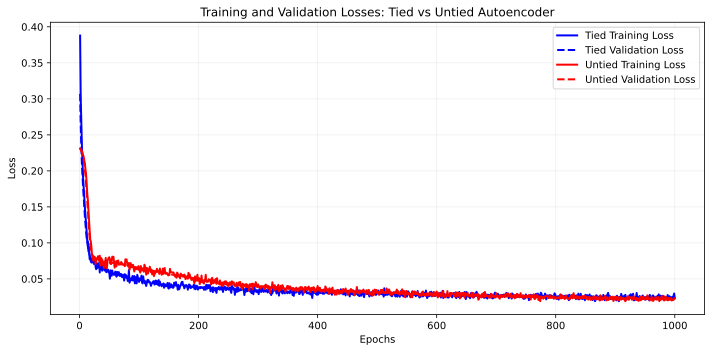


Tied Autoencoder Reconstructions:


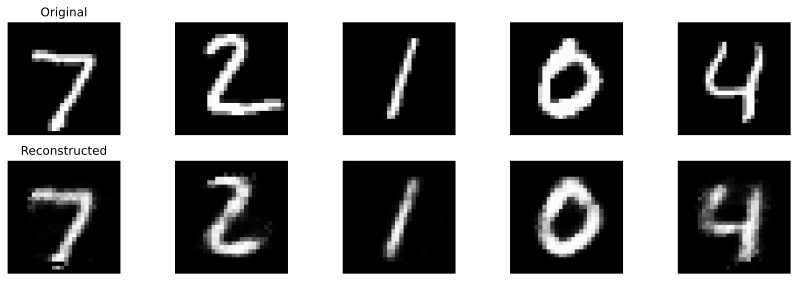


Untied Autoencoder Reconstructions:


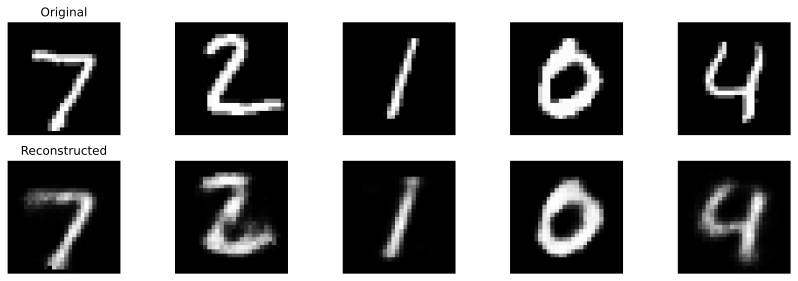

In [104]:
results, tied_model, untied_model = compare_models(epochs=1000, batch_size=32)

In [105]:
# grab a small set of images
X = dataTest[:50,:]

# add noise
Xnoise = X + torch.rand_like(X)/4

# clip at 1
Xnoise[Xnoise>1] = 1

In [106]:
Y_tied = tied_model(Xnoise)

In [107]:
Y_untied = untied_model(Xnoise)

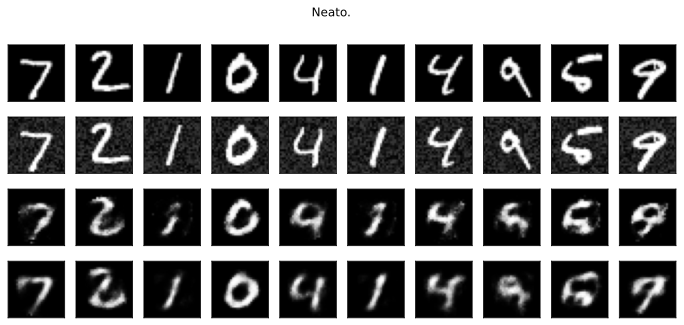

In [108]:
# show the noisy images
fig,axs = plt.subplots(4,10,figsize=(12,5))

for i in range(10):
  axs[0,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].imshow(Xnoise[i,:].view(28,28).detach() ,cmap='gray')
  axs[2,i].imshow(Y_tied[i,:].view(28,28).detach() ,cmap='gray')
  axs[3,i].imshow(Y_untied[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])
  axs[2,i].set_xticks([]), axs[2,i].set_yticks([])
  axs[3,i].set_xticks([]), axs[3,i].set_yticks([])
plt.suptitle('Neato.')
plt.show()

In [109]:
criterion = nn.MSELoss()
criterion(Y_tied, X).item()

0.03736698627471924

In [110]:
criterion(Y_untied, X).item()

0.027720006182789803

In [111]:
import copy
# grab a small set of images
X_occlude = copy.deepcopy( X )

# add noise
for i in range(X_occlude.shape[0]):
  
  # reshape the image
  img = X_occlude[i,:].view(28,28)

  # occlude random rows or columns
  startloc = np.random.choice(range(10,21))
  if i%2==0: # even -> horizontal occlusion
    img[startloc:startloc+1,:] = 1
  else:      # odd -> vertical occlusion
    img[:,startloc:startloc+1] = 1


In [112]:
# run the samples through the model
Y_tied_deOccluded = tied_model(X_occlude)

In [113]:
# run the samples through the model
Y_untied_deOccluded = untied_model(X_occlude)

In [114]:
criterion(Y_tied_deOccluded, X).item()

0.030961839482188225

In [115]:
criterion(Y_untied_deOccluded, X).item()

0.024241076782345772